# On Prevalence & Risk

In [156]:
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

from matplotlib.patches import Patch
from matplotlib.lines import Line2D



import pandas as pd
import numpy as np

from loguru import logger
import pycountry

from matplotlib.pylab import plt
import seaborn as sns


import plotly_express as px

import chart_studio.plotly as py
import chart_studio

from scipy import stats
from sympy import Point, Line





%matplotlib inline

# Load the Ireland Dataset

In [157]:
base_ireland_dataset = '../../generating_covid_datasets/data/base_ireland.pkl'

df = pd.read_pickle(base_ireland_dataset)
df.shape, df.date.max()

((4680, 11), Timestamp('2020-08-24 00:00:00+0000', tz='UTC'))

In [3]:
# df = df[df['date']<pd.to_datetime('2020-08-23').tz_localize('UTC')]
# df.shape, df.date.max()

# Prevalence

In [158]:
infectous_period = 14  # Number of days someone remains infectous

df = df.set_index(['county', 'date']).join(df.groupby('county').apply(
    lambda g: g.set_index('date')[['new_cases']].clip(lower=0).shift(infectous_period)).rename(columns={'new_cases': 'new_recovered'})).reset_index()

df = df.set_index(['county', 'date']).join(df.groupby('county').apply(
    lambda g: g.set_index('date')[['new_cases']].clip(lower=0).cumsum()).rename(columns={'new_cases': 'cum_cases'})).reset_index()

df = df.set_index(['county', 'date']).join(df.groupby('county').apply(
    lambda g: g.set_index('date')[['new_recovered']].cumsum()).rename(columns={'new_recovered': 'cum_recovered'})).reset_index()

df.shape

(4680, 14)

In [159]:
df['curr_cases'] = df['cum_cases']-df['cum_recovered']
df['curr_cases_per_100k'] = 100000*df['curr_cases']/df['population']

df['new_cases_per_100k'] = 100000*df['new_cases']/df['population']

df.shape

(4680, 17)

In [160]:
lockdown_start, lockdown_end = pd.to_datetime('2020-03-15').tz_localize('UTC'), pd.to_datetime('2020-05-18').tz_localize('UTC')
summer_start, summer_end = pd.to_datetime('2020-06-01').tz_localize('UTC'), pd.to_datetime('2020-07-31').tz_localize('UTC')

df = df.set_index(['county', 'date']).join(df.groupby('county').apply(
    lambda cases_per_100k: cases_per_100k.set_index('date').loc[lockdown_start:lockdown_end][['curr_cases_per_100k']].mean()
).rename(columns={'curr_cases_per_100k': 'lockdown_prevalence'})).reset_index()

df = df.set_index(['county', 'date']).join(df.groupby('county').apply(
    lambda cases_per_100k: cases_per_100k.set_index('date').loc[summer_start:summer_end][['curr_cases_per_100k']].mean()
).rename(columns={'curr_cases_per_100k': 'summer_prevalence'})).reset_index()


# df = df.set_index(['county', 'date']).join(df.groupby('county').apply(
#     lambda cases_per_100k: cases_per_100k.set_index('date')[['curr_cases_per_100k']]/cases_per_100k.set_index('date').loc[lockdown_start:lockdown_end]['curr_cases_per_100k'].mean()
# ).rename(columns={'curr_cases_per_100k': 'rel_lockdown_prevalence'})).reset_index()
                                           
# df = df.set_index(['county', 'date']).join(df.groupby('county').apply(
#     lambda cases_per_100k: cases_per_100k.set_index('date')[['curr_cases_per_100k']]/cases_per_100k.set_index('date').loc[summer_start:summer_end]['curr_cases_per_100k'].mean()
# ).rename(columns={'curr_cases_per_100k': 'rel_summer_prevalence'})).reset_index()
                                       
    
df['rel_lockdown_prevalence'] = df['curr_cases_per_100k']/df['lockdown_prevalence']
df['rel_summer_prevalence'] = df['curr_cases_per_100k']/df['summer_prevalence']

df['mean_rel_prevalence'] = (df['rel_lockdown_prevalence']+df['rel_summer_prevalence'])/2

df.shape                                         

(4680, 22)

In [161]:
rel_summer_prevalence_orange_limit = 1
rel_lockdown_prevalence_red_limit = 1

def assign_quadrant(s):
    
    if s['rel_summer_prevalence']<rel_summer_prevalence_orange_limit:
        return 'yellow'
    elif s['rel_lockdown_prevalence']<rel_lockdown_prevalence_red_limit:
        return 'orange'
    else:
        return 'red'
    
df['quadrant'] = df.apply(
    lambda row: assign_quadrant(row), axis=1
)

# Visualising Current Prevalence

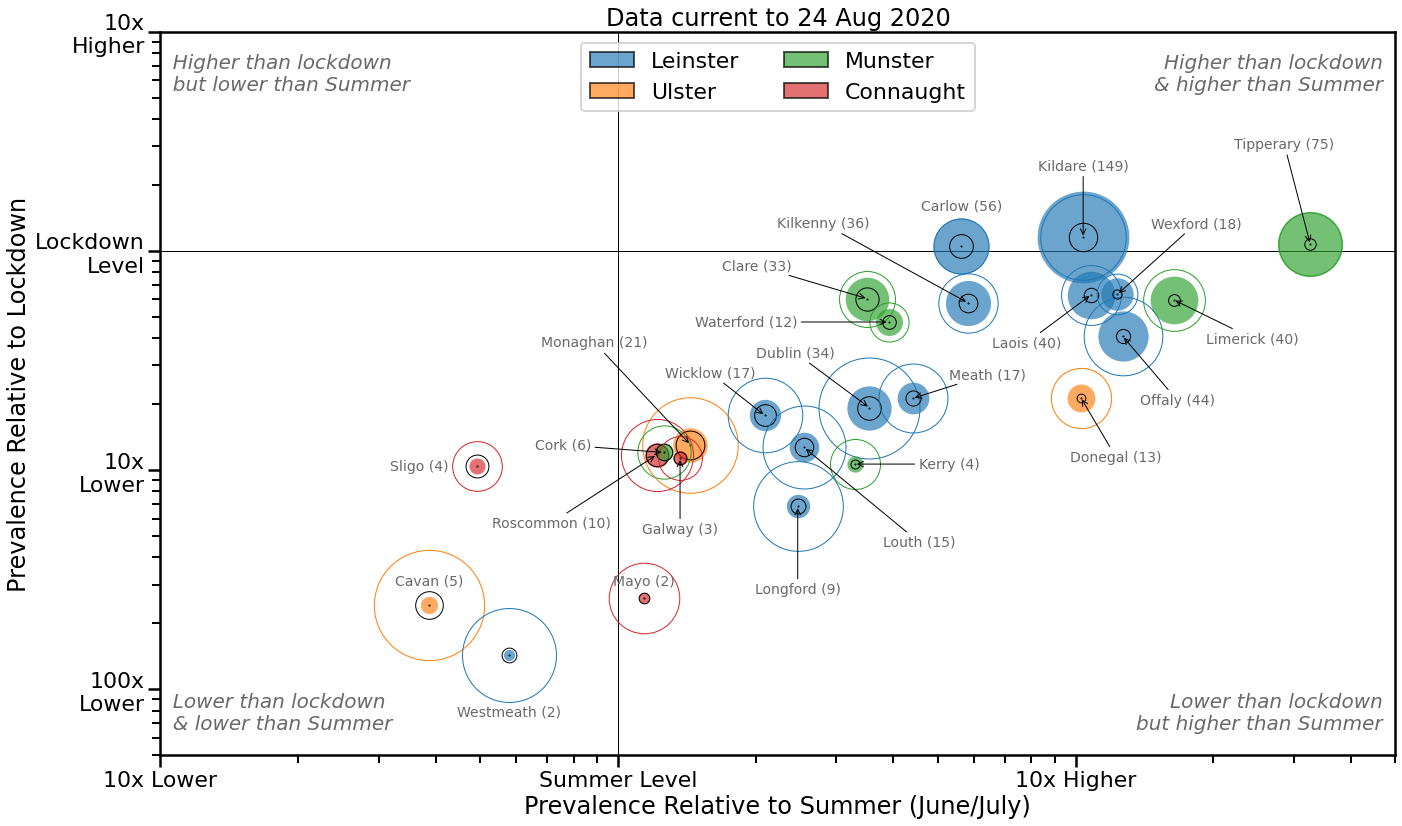

In [266]:
colour_zones = False

sns.set_context('poster')

fig, ax = plt.subplots(figsize=(20, 12))

current_df = df.groupby('county').last()

palette = dict(zip(current_df.province.unique(), sns.color_palette("tab10", current_df.province.nunique())))

# palette = dict(zip(current_df.province.unique(), ['steelblue', 'purple', 'forestgreen', 'plum']))

size_scale = 7.5


# The backgrounds


ax.set_xlim(.1, 50)
ax.set_ylim(.005, 10)


median_rel_summer_relevance = current_df['rel_summer_prevalence'].median()
median_rel_lockdown_relevance = current_df['rel_lockdown_prevalence'].median()

if colour_zones:
    ax.fill_between(
        [ax.get_xlim()[0], rel_summer_prevalence_orange_limit], 
        [rel_lockdown_prevalence_red_limit, rel_lockdown_prevalence_red_limit], 
        color='lightyellow', alpha=.5
    )

    ax.fill_between(
        [rel_summer_prevalence_orange_limit, ax.get_xlim()[1]], 
        [rel_lockdown_prevalence_red_limit, rel_lockdown_prevalence_red_limit], 
        color='orange', alpha=.25
    )


    ax.fill_between(
        [rel_summer_prevalence_orange_limit, ax.get_xlim()[1]], 
        [ax.get_ylim()[1], ax.get_ylim()[1]], 
        color='red', alpha=.25
    )

ax.axvline(rel_summer_prevalence_orange_limit, c='k', lw=1, ls='-', zorder=-100)
ax.plot([rel_summer_prevalence_orange_limit, ax.get_xlim()[1]], [rel_lockdown_prevalence_red_limit]*2, c='k', lw=1, ls='-', zorder=-100)
ax.plot([ax.get_xlim()[0], rel_summer_prevalence_orange_limit], [rel_lockdown_prevalence_red_limit]*2, c='k', lw=1, ls='-', zorder=-100)






for county, data in current_df.sort_values(by='curr_cases_per_100k', ascending=False).iterrows():
    
    x, y = data['rel_summer_prevalence'], data['rel_lockdown_prevalence']
    
    lockdown_prevalence = data['lockdown_prevalence']
    summer_prevalence = data['summer_prevalence']
    curr_prevalence = data['curr_cases_per_100k']
    
    province = data['province']
    
    ax.plot([x], [y], marker='o', markersize=(curr_prevalence**.5)*size_scale, color=palette[province], alpha=.66, markeredgecolor='k', markeredgewidth=0)
    ax.plot([x], [y], marker='o', markersize=(lockdown_prevalence**.5)*size_scale, markeredgecolor=palette[province], markeredgewidth=1, markerfacecolor='none')
    ax.plot([x], [y], marker='o', markersize=(summer_prevalence**.5)*size_scale, markeredgecolor='k', markeredgewidth=1, markerfacecolor='none')


    ax.plot([x], [y], marker='o', markersize=1, color='k')




ax.set_xlabel('Prevalence Relative to Summer (June/July)')
ax.set_ylabel('Prevalence Relative to Lockdown')


legend_elements = [Patch(facecolor=palette[province], alpha=.66, edgecolor='k', label=province)
 for province in df.province.unique()]

ax.legend(handles=legend_elements, ncol=2, loc='upper center')

county_offsets = [
    ('Galway', -0, -.06, True),
#     ('Leitrim', .015, .02, True),
    ('Mayo', 0, .005, False),
    ('Roscommon', -.5, -.06, True),
    ('Sligo', -.125, 0, False),
    
    ('Carlow', 0, .55, False),
    ('Dublin', -1.1, .15, True),
    ('Kildare', 0, 1.3, True),
    ('Kilkenny', -3, .75, True),
    ('Laois', -3, -.25, True),
    ('Longford', 0, -.04, True),
    ('Louth', 2, -.08, True),
    ('Meath', 2, 0.06, True),
    ('Offaly', 4, -.2, True),
    ('Westmeath', 0, -0.0065, False),
    ('Wexford', 6, .7, True),
    ('Wicklow', -.5, .1, True),

    ('Clare', -1.5, .25, True),
    ('Cork', -.5, .01, True),
    ('Kerry', 2, 0, True),
    ('Limerick', 8, -.2, True),
    ('Tipperary', -4, 2, True),
    ('Waterford', -2, 0, True),

    ('Cavan', 0, 0.007, False),
    ('Donegal', 2, -.1, True),
    ('Monaghan', -.55, .25, True),

]

for county, xoffset, yoffset, use_arrow in county_offsets:
    
    x = current_df.loc[county]['rel_summer_prevalence']
    y = current_df.loc[county]['rel_lockdown_prevalence']
    s = int(current_df.loc[county]['curr_cases_per_100k'])
    
    if x<ax.get_xlim()[0]: x = ax.get_xlim()[0]
    if y<ax.get_ylim()[0]: y = ax.get_ylim()[0]

    
    if use_arrow:
        ax.annotate(
            '{} ({})'.format(county, s), 
            xy=(x, y), xytext=(x+xoffset, y+yoffset),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3", lw=1),
            fontsize=14, color='dimgrey', ha='center', va='center'
        )
    else:
        ax.annotate(
            '{} ({})'.format(county, s), 
            xy=(x, y), xytext=(x+xoffset, y+yoffset),
            fontsize=14, color='dimgrey', ha='center', va='center'
        )

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xticklabels([0, '10x Lower', 'Summer Level', '10x Higher'])
ax.set_yticklabels([0, 0, '100x\nLower', '10x\nLower', 'Lockdown\nLevel', '10x\nHigher'])


ax.text(ax.get_xlim()[0], ax.get_ylim()[0], '  Lower than lockdown\n  & lower than Summer\n', ha='left', va='bottom', color='dimgrey', fontsize=20, style='oblique')
ax.text(ax.get_xlim()[0], ax.get_ylim()[1], '\n  Higher than lockdown\n  but lower than Summer', ha='left', va='top', color='dimgrey', fontsize=20, style='oblique')

ax.text(ax.get_xlim()[1], ax.get_ylim()[0], 'Lower than lockdown  \nbut higher than Summer  \n', ha='right', va='bottom', color='dimgrey', fontsize=20, style='oblique')
ax.text(ax.get_xlim()[1], ax.get_ylim()[1], '\nHigher than lockdown  \n& higher than Summer  ', ha='right', va='top', color='dimgrey', fontsize=20, style='oblique')

ax.set_title('Data current to {}'.format(datetime.strftime(current_df['date'].unique()[0], '%d %b %Y')))


fig.tight_layout()

fig.savefig('../graphs/lockdown_vs_summer_rel_prevalence.png', format='png', dpi=200)